In [1]:
import pandas as pd  #pacotes
import numpy as np   #calculo numerico
import glob          #listas
#Codigo para declarar um pyarrow parquet - Willian - 29/05/2018
import pyarrow.parquet as pq
#uproot serve para ler a partir o python um arquivo em tree root
#import uproot
import os, sys
from os import path
import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
from matplotlib.colors import BoundaryNorm
%matplotlib inline

## MEDIDAS COM TEMPO ABAIXO DE 5us (STOPPING MUONS)

In [2]:
%run def_functions.ipynb
%run def_functions_hits.ipynb
%run def_functions_fits.ipynb


In [3]:

# para 4 x 7 dias

list_ON1 = ['20200820','20200821','20200822','20200823','20200824','20200825','20200826']
list_ON2 = ['20200827','20200828','20200829','20200830','20200831','20200901','20200902']
list_ON3 = ['20200903','20200904','20200905','20200906','20200907','20200908','20200909']
list_ON4 = ['20200910','20200911','20200912','20200913','20200924','20200925','20200926']
#           '20200927','20200928'

list_OFF1 = ['20200624','20200625','20200626','20200627','20200628','20200629','20200630']
list_OFF2 = ['20200701','20200702','20200703','20200704','20200705','20200706','20200707']
list_OFF3 = ['20200708','20200709','20200710','20200711','20200712','20200713','20200714']
list_OFF4 = ['20200715','20200716','20200717','20200718','20200719','20200720','20200721']
#            '20200722','20200723'

list_ONO1 = ['20201001','20201002','20201003','20201004','20201005','20201006','20201007']
list_ONO2 = ['20201008','20201009','20201010','20201011','20201012','20201013','20201014']
list_ONO3 = ['20201015','20201016','20201017','20201018','20201019','20201020','20201021']
list_ONO4 = ['20201022','20201023','20201024','20201025','20201026','20201027','20201028']
#            '20201029','20201030'


In [4]:
#chi_sq_tab = 2.366  # chi quadrado tabelado para 3 graus de liberdades com 50%
#chi_sq_tab = 6.251  # chi quadrado tabelado para 3 graus de liberdades com 90%
chi_sq_tab = 7.815  # chi quadrado tabelado para 3 graus de liberdades com 95%
#chi_sq_tab = 10.597  # chi quadrado tabelado para 3 graus de liberdades com 995%
rh, rw = 150, 150
prompt_mean, prompt_var = 61.45215100965759, 1337.7332240825515
delay_mean, delay_var = 94.3970297029703, 4899.284941672385 
time_mean, time_var = 12.70, 12.70
itime_mean, itime_var = 1/12.70, 1/(12.70**2)

IBD_Esperado = 6610 #eventos por dia


## Função para processar lista

In [88]:
def fnt_process_list_PD (p_list, p_h_PDP, p_h_PDD, p_h_PDT, p_h_MUP, p_h_MUD, p_h_DPMTs):
    p_totalMuons = 0
    p_totalNonSat = 0
    
    print('fnt_process_list_PD - v3')

    for sListDt in p_list:
        yyyy=int(sListDt[0:4]); mm=int(sListDt[4:6]); dd=int(sListDt[6:8])
    
        sDate = '{0:d}-{1:0>2d}-{2:0>2d}'.format(yyyy,mm,dd)
        sDir='data/{0:d}{1:0>2d}{2:0>2d}'.format(yyyy,mm,dd)
        print(sDir)
        lista = find_interval_date_pair(sDate,sDate,sDir)

        for file in lista:
            df = pd.read_parquet(file)
            dff = df[#(df['p_satured']==0)&(df['d_satured']==0)
                            #&(fnt_pe2MeV(df['p_Total_pe'])>=3)&(fnt_pe2MeV(df['p_Total_pe'])<=10)
                            #&(fnt_pe2MeV(df['d_Total_pe'])>=1.6)&(fnt_pe2MeV(df['d_Total_pe'])<=7.12)
                            #&(df['d_timeInverval']>=8)&(df['d_timeInverval']<=50)
                            #&
                            (df['d_timeInverval']<=6)
                           # &(df['d_mPMTs']>=25)
                    ]
            p_h_PDP.extend(dff['p_Total_pe'].values)
            p_h_MUP.extend(dff['p_mPMTs'].values)
            p_h_PDD.extend(dff['d_Total_pe'].values)
            p_h_MUD.extend(dff['d_mPMTs'].values)
            p_h_PDT.extend(dff['d_timeInverval'].values)
            
            #print('d_timeInverval = ',dff['d_timeInverval'].head(1))
            
            for iPMT in range(32):
                siPMT = '{0:0>2d}'.format(iPMT+1)
                #print(siPMT)
                p_h_DPMTs[iPMT].extend(dff['d_PMT'+siPMT].values)
                #aqui as PMTs estão em DUQ e batem com d_Total_charge 
                #pode haver valores negativos, que não entram na conta do d_Total_charge
                #d_Total_pe = d_Total_charge / 77,96
                
                #print('d_PMT'+siPMT+' = ',dff['d_PMT'+siPMT].head(1))
                
            #print('d_Total_charge = ',dff['d_Total_charge'].head(1))
            #print('d_Total_pe = ',dff['d_Total_pe'].head(1))
            

            dfns = df[(df['p_satured']==0)&(df['d_satured']==0)]

            p_totalMuons += df.count()[0]
            p_totalNonSat += dfns.count()[0]

            #break

    return p_totalMuons, p_totalNonSat


In [115]:
def fnt_process_list_PD_2 (p_list, p_h_PDP, p_h_PDD, p_h_PDT, p_h_MUP, p_h_MUD, p_h_DPMTs):
    p_totalMuons = 0
    p_totalNonSat = 0
    
    print('fnt_process_list_PD_2 - v3')

    for sListDt in p_list:
        yyyy=int(sListDt[0:4]); mm=int(sListDt[4:6]); dd=int(sListDt[6:8])
    
        sDate = '{0:d}-{1:0>2d}-{2:0>2d}'.format(yyyy,mm,dd)
        sDir='data/{0:d}{1:0>2d}{2:0>2d}'.format(yyyy,mm,dd)
        print(sDir)
        lista = find_interval_date_pair(sDate,sDate,sDir)

        for file in lista:
            df = pd.read_parquet(file)
            dff = df[(df['d_timeInverval']>6)&(df['d_timeInverval']<=12)]
            p_h_PDP.extend(dff['p_Total_pe'].values)
            p_h_MUP.extend(dff['p_mPMTs'].values)
            p_h_PDD.extend(dff['d_Total_pe'].values)
            p_h_MUD.extend(dff['d_mPMTs'].values)
            p_h_PDT.extend(dff['d_timeInverval'].values)
            
            #print('d_timeInverval = ',dff['d_timeInverval'].head(1))
            
            for iPMT in range(32):
                siPMT = '{0:0>2d}'.format(iPMT+1)
                #print(siPMT)
                p_h_DPMTs[iPMT].extend(dff['d_PMT'+siPMT].values)
                #aqui as PMTs estão em DUQ e batem com d_Total_charge 
                #pode haver valores negativos, que não entram na conta do d_Total_charge
                #d_Total_pe = d_Total_charge / 77,96
                
                #print('d_PMT'+siPMT+' = ',dff['d_PMT'+siPMT].head(1))
                
            #print('d_Total_charge = ',dff['d_Total_charge'].head(1))
            #print('d_Total_pe = ',dff['d_Total_pe'].head(1))
            

            dfns = df[(df['p_satured']==0)&(df['d_satured']==0)]

            p_totalMuons += df.count()[0]
            p_totalNonSat += dfns.count()[0]

            #break

    return p_totalMuons, p_totalNonSat


In [129]:
def fnt_process_list_PD_3 (p_list, p_h_PDP, p_h_PDD, p_h_PDT, p_h_MUP, p_h_MUD, p_h_DPMTs, i_Sub): 
    #i_Sub = 1: t<6; i_Sub = 2: 6<t<12
    
    p_totalMuons = 0
    p_totalNonSat = 0
    
    print('fnt_process_list_PD_3 - v3, i_Sub = ',i_Sub)

    for sListDt in p_list:
        yyyy=int(sListDt[0:4]); mm=int(sListDt[4:6]); dd=int(sListDt[6:8])
    
        sDate = '{0:d}-{1:0>2d}-{2:0>2d}'.format(yyyy,mm,dd)
        sDir='data/{0:d}{1:0>2d}{2:0>2d}'.format(yyyy,mm,dd)
        print(sDir)
        lista = find_interval_date_pair(sDate,sDate,sDir)

        for file in lista:
            df = pd.read_parquet(file)
            if (i_Sub==1):
                dff = df[(df['p_Total_charge']>50000)&(df['p_Total_charge']<75000)
                     &(df['d_timeInverval']<6)]
            else:
                dff = df[(df['p_Total_charge']>50000)&(df['p_Total_charge']<75000)
                     &(df['d_timeInverval']>6)&(df['d_timeInverval']<12)]
            p_h_PDP.extend(dff['p_Total_pe'].values)
            p_h_MUP.extend(dff['p_mPMTs'].values)
            p_h_PDD.extend(dff['d_Total_pe'].values)
            p_h_MUD.extend(dff['d_mPMTs'].values)
            p_h_PDT.extend(dff['d_timeInverval'].values)
            
            #print('d_timeInverval = ',dff['d_timeInverval'].head(1))
            
            for iPMT in range(32):
                siPMT = '{0:0>2d}'.format(iPMT+1)
                #print(siPMT)
                p_h_DPMTs[iPMT].extend(dff['d_PMT'+siPMT].values)
                #aqui as PMTs estão em DUQ e batem com d_Total_charge 
                #pode haver valores negativos, que não entram na conta do d_Total_charge
                #d_Total_pe = d_Total_charge / 77,96
                
                #print('d_PMT'+siPMT+' = ',dff['d_PMT'+siPMT].head(1))
                
            #print('d_Total_charge = ',dff['d_Total_charge'].head(1))
            #print('d_Total_pe = ',dff['d_Total_pe'].head(1))
            

            dfns = df[(df['p_satured']==0)&(df['d_satured']==0)]

            p_totalMuons += df.count()[0]
            p_totalNonSat += dfns.count()[0]

            #break

    return p_totalMuons, p_totalNonSat


## Salvar e carregar Listas ON / OFF

In [16]:
##save values - h_Sig_OFF2 (contém o sigma de cada bin dividido por 5dias)
def save_PD (dh_PDP, dh_MUP, dh_PDD, dh_MUD, dh_PDT, dh_DPMT, sName):
    # dictionary of lists
    dict = {'dh_PDP': dh_PDP,
            'dh_MUP': dh_MUP,
            'dh_PDD': dh_PDD,
            'dh_MUD': dh_MUD,
            'dh_PDT': dh_PDT,
            'dh_DPMT': dh_DPMT}
    
    # creating a dataframe from dictionary
    dfw = pd.DataFrame(dict)
    dfw.to_parquet('data/Analise_ONOFF/'+sName+'.parq', compression='gzip')

    del dict
    
##load values
def load_PD (sName): #(dh_PDP, dh_PDD, dh_PDT, dh_DPMT, sName):
    dfr = pd.read_parquet('data/Analise_ONOFF/'+sName+'.parq')
    return(dfr['dh_PDP'].values, dfr['dh_MUP'].values, dfr['dh_PDD'].values, dfr['dh_MUD'].values, dfr['dh_PDT'].values, dfr['dh_DPMT'].values)

    

## Processamento para OFF1

In [14]:
h_DPMT_OFF1 = [[] for i in range(32)]
for iPMT in range(32):
    siPMT = '{0:0>2d}'.format(iPMT+1)
   # print(siPMT)
    h_DPMT_OFF1[iPMT].extend([iPMT])
print(h_DPMT_OFF1)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31]]


In [89]:
print('Inicio',datetime.datetime.now())

h_PDP_OFF1 = []
h_MUP_OFF1 = []
h_PDD_OFF1 = []
h_MUD_OFF1 = []
h_PDT_OFF1 = []
h_DPMT_OFF1 = [[] for i in range(32)]
totalMuons_OFF1 = 0
totalNonSat_OFF1 = 0

list_OFF1 = ['20200701']
totalMuons_OFF1, totalNonSat_OFF1 = fnt_process_list_PD(list_OFF1, h_PDP_OFF1, h_PDD_OFF1, h_PDT_OFF1, h_MUP_OFF1, h_MUD_OFF1, h_DPMT_OFF1)
                            
print(len(h_PDP_OFF1))
print('Em ',len(list_OFF1),' dias: ',totalMuons_OFF1)
print('Por dia: ',totalMuons_OFF1/len(list_OFF1))
print('Em ',len(list_OFF1),' dias (NS): ',totalNonSat_OFF1)
print('Por dia (NS): ',totalNonSat_OFF1/len(list_OFF1))

        
print('Fim',datetime.datetime.now())

Inicio 2023-12-21 17:49:41.357601
fnt_process_list_PD - v3
data/20200701
68763
Em  1  dias:  16823250
Por dia:  16823250.0
Em  1  dias (NS):  10588204
Por dia (NS):  10588204.0
Fim 2023-12-21 17:54:13.203965


In [90]:
print('Inicio',datetime.datetime.now())

h_PDP_ON1 = []
h_MUP_ON1 = []
h_PDD_ON1 = []
h_MUD_ON1 = []
h_PDT_ON1 = []
h_DPMT_ON1 = [[] for i in range(32)]  ## contém single photoelectron (SPE) de cada PMT
totalMuons_ON1 = 0
totalNonSat_ON1 = 0

list_ON1 = ['20201001']
totalMuons_ON1, totalNonSat_ON1 = fnt_process_list_PD(list_ON1, h_PDP_ON1, h_PDD_ON1, h_PDT_ON1, h_MUP_ON1, h_MUD_ON1, h_DPMT_ON1)
                            
print(len(h_PDP_ON1))
print('Em ',len(list_ON1),' dias: ',totalMuons_ON1)
print('Por dia: ',totalMuons_ON1/len(list_ON1))
print('Em ',len(list_ON1),' dias (NS): ',totalNonSat_ON1)
print('Por dia (NS): ',totalNonSat_ON1/len(list_ON1))

        
print('Fim',datetime.datetime.now())

Inicio 2023-12-21 17:54:13.375086
fnt_process_list_PD - v3
data/20201001
66735
Em  1  dias:  16444875
Por dia:  16444875.0
Em  1  dias (NS):  10653050
Por dia (NS):  10653050.0
Fim 2023-12-21 17:58:47.250924


In [124]:
print('Inicio',datetime.datetime.now())

h_PDP_ON1_2 = []
h_MUP_ON1_2 = []
h_PDD_ON1_2 = []
h_MUD_ON1_2 = []
h_PDT_ON1_2 = []
h_DPMT_ON1_2 = [[] for i in range(32)]  ## contém single photoelectron (SPE) de cada PMT
totalMuons_ON1_2 = 0
totalNonSat_ON1_2 = 0

list_ON1_2 = ['20201001']
totalMuons_ON1_2, totalNonSat_ON1_2 = fnt_process_list_PD_3(list_ON1_2, h_PDP_ON1_2, h_PDD_ON1_2, h_PDT_ON1_2, h_MUP_ON1_2, h_MUD_ON1_2, h_DPMT_ON1_2, 2)
                            
print(len(h_PDP_ON1_2))
print('Em ',len(list_ON1_2),' dias: ',totalMuons_ON1_2)
print('Por dia: ',totalMuons_ON1_2/len(list_ON1_2))
print('Em ',len(list_ON1_2),' dias (NS): ',totalNonSat_ON1_2)
print('Por dia (NS): ',totalNonSat_ON1_2/len(list_ON1_2))

        
print('Fim',datetime.datetime.now())

Inicio 2023-12-22 02:39:06.512685
fnt_process_list_PD_3 - v3
data/20201001
1529
Em  1  dias:  16444875
Por dia:  16444875.0
Em  1  dias (NS):  10653050
Por dia (NS):  10653050.0
Fim 2023-12-22 02:43:47.723721


In [130]:
print('Inicio',datetime.datetime.now())

h_PDP_ON1_1 = []
h_MUP_ON1_1 = []
h_PDD_ON1_1 = []
h_MUD_ON1_1 = []
h_PDT_ON1_1 = []
h_DPMT_ON1_1 = [[] for i in range(32)]  ## contém single photoelectron (SPE) de cada PMT
totalMuons_ON1_1 = 0
totalNonSat_ON1_1 = 0

list_ON1_1 = ['20201001']
totalMuons_ON1_1, totalNonSat_ON1_1 = fnt_process_list_PD_3(list_ON1_1, h_PDP_ON1_1, h_PDD_ON1_1, h_PDT_ON1_1, h_MUP_ON1_1, h_MUD_ON1_1, h_DPMT_ON1_1, 1)
                            
print(len(h_PDP_ON1_1))
print('Em ',len(list_ON1_1),' dias: ',totalMuons_ON1_1)
print('Por dia: ',totalMuons_ON1_1/len(list_ON1_1))
print('Em ',len(list_ON1_1),' dias (NS): ',totalNonSat_ON1_1)
print('Por dia (NS): ',totalNonSat_ON1_1/len(list_ON1_1))

        
print('Fim',datetime.datetime.now())

Inicio 2023-12-22 02:51:52.275414
fnt_process_list_PD_3 - v3, i_Sub =  1
data/20201001
3191
Em  1  dias:  16444875
Por dia:  16444875.0
Em  1  dias (NS):  10653050
Por dia (NS):  10653050.0
Fim 2023-12-22 02:56:13.608320


## Segunda análise para 10 dias

In [93]:
print('Inicio',datetime.datetime.now())

h_PDP_ON2 = []
h_MUP_ON2 = []
h_PDD_ON2 = []
h_MUD_ON2 = []
h_PDT_ON2 = []
h_DPMT_ON2 = [[] for i in range(32)]  ## contém single photoelectron (SPE) de cada PMT
totalMuons_ON2 = 0
totalNonSat_ON2 = 0

list_ON2 = ['20201001','20201002','20201003','20201004','20201005','20201006','20201007','20201008','20201009','20201010']
totalMuons_ON2, totalNonSat_ON2 = fnt_process_list_PD(list_ON2, h_PDP_ON2, h_PDD_ON2, h_PDT_ON2, h_MUP_ON2, h_MUD_ON2, h_DPMT_ON2)
                            
print(len(h_PDP_ON2))
print('Em ',len(list_ON2),' dias: ',totalMuons_ON2)
print('Por dia: ',totalMuons_ON2/len(list_ON2))
print('Em ',len(list_ON2),' dias (NS): ',totalNonSat_ON2)
print('Por dia (NS): ',totalNonSat_ON2/len(list_ON2))

        
print('Fim',datetime.datetime.now())

Inicio 2023-12-21 18:04:05.423872
fnt_process_list_PD - v3
data/20201001
data/20201002
data/20201003
data/20201004
data/20201005
data/20201006
data/20201007
data/20201008
data/20201009
data/20201010
652255
Em  10  dias:  161112305
Por dia:  16111230.5
Em  10  dias (NS):  106113838
Por dia (NS):  10611383.8
Fim 2023-12-21 18:48:05.549513


In [94]:
print('Inicio',datetime.datetime.now())

h_PDP_OFF2 = []
h_MUP_OFF2 = []
h_PDD_OFF2 = []
h_MUD_OFF2 = []
h_PDT_OFF2 = []
h_DPMT_OFF2 = [[] for i in range(32)]  ## contém single photoelectron (SPE) de cada PMT
totalMuons_OFF2 = 0
totalNonSat_OFF2 = 0

list_OFF2 = ['20200701','20200702','20200703','20200704','20200705','20200706','20200707','20200708','20200709','20200710']
totalMuons_OFF2, totalNonSat_OFF2 = fnt_process_list_PD(list_OFF2, h_PDP_OFF2, h_PDD_OFF2, h_PDT_OFF2, h_MUP_OFF2, h_MUD_OFF2, h_DPMT_OFF2)
                            
print(len(h_PDP_OFF2))
print('Em ',len(list_OFF2),' dias: ',totalMuons_OFF2)
print('Por dia: ',totalMuons_OFF2/len(list_OFF2))
print('Em ',len(list_OFF2),' dias (NS): ',totalNonSat_OFF2)
print('Por dia (NS): ',totalNonSat_OFF2/len(list_OFF2))

        
print('Fim',datetime.datetime.now())

Inicio 2023-12-21 18:48:05.716623
fnt_process_list_PD - v3
data/20200701
data/20200702
data/20200703
data/20200704
data/20200705
data/20200706
data/20200707
data/20200708
data/20200709
data/20200710
654865
Em  10  dias:  165096869
Por dia:  16509686.9
Em  10  dias (NS):  106316773
Por dia (NS):  10631677.3
Fim 2023-12-21 19:32:39.305663


## Análises

## 1 dia ON / OFF

No handles with labels found to put in legend.


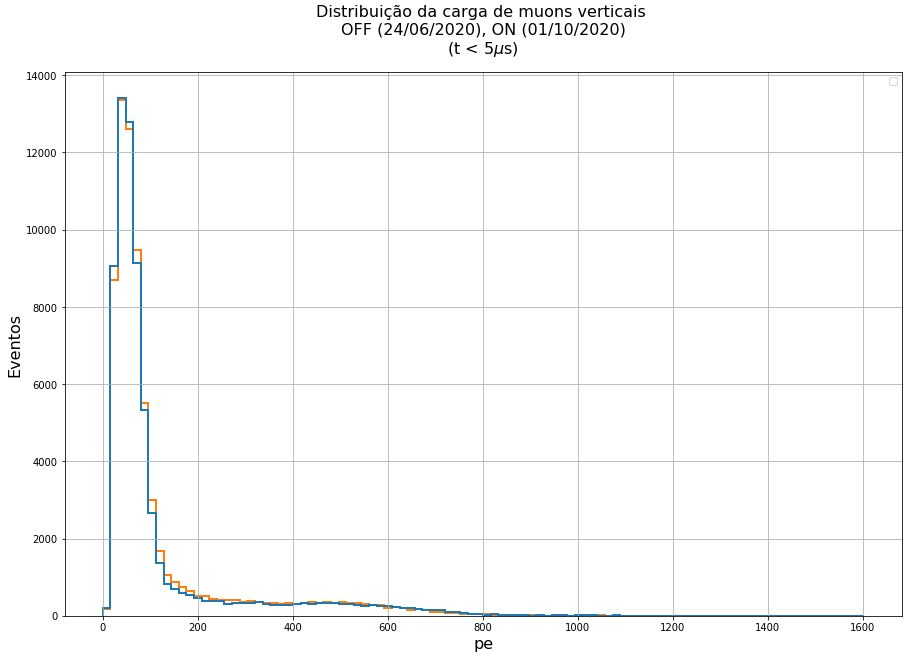

max pe ON =  1901.8086198050285
max pe OFF =  1692.4320164186763
10pe =  0.997 MeV
50pe =  2.505 MeV
100pe =  4.39 MeV
150pe =  6.2749999999999995 MeV
200pe =  8.159999999999998 MeV
400pe =  15.699999999999998 MeV
600pe =  23.24 MeV
800pe =  30.779999999999998 MeV


In [104]:
#from matplotlib.lines import Line2D

fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 10})


#h_histPMT = [h_DPMT_OFF1[xi] for xi in range(32)]  ## contém single photoelectron (SPE) de cada PMT
#h_legPMT = ['PMT{0:0>2d}'.format(xi+1) for xi in range(32)]
#legend_elements = [Line2D([0], [0], lw=1, label='PMT{0:0>2d}'.format(xi+1)) for xi in range(32)]

#plt.hist(h_PDD_OFF1, bins = 90, histtype='step')
#plt.hist(h_histPMT, bins =1200, histtype='step', label=h_legPMT)
plt.hist([h_PDD_ON1,h_PDD_OFF1], bins =100, histtype='step', linewidth=2)
#plt.hist([h_PDD_OFF1,h_PDP_OFF1], bins =100, histtype='step')
plt.ylabel('Eventos', size=16)
#plt.xlabel('Charge (DUQ)', size=16)
plt.xlabel('pe', size=16)
plt.legend(loc="upper right")
plt.grid()
#plt.xlim(0,500)
#plt.xlim(0,300)
#ax.legend(handles=legend_elements, loc="upper right")
plt.title('Distribuição da carga de muons verticais \n'+
          'OFF (01/07/2020), ON (01/10/2020)\n'+
          r'(t < 5$\mu$s)', size=16,y=1.02)
#plt.savefig('histogramas/Hist_Mult_Delay_ON_OFF_crit.png')
plt.show()

print('max pe ON = ',max(h_PDP_ON1))
print('max pe OFF = ',max(h_PDP_OFF1))
print('10pe = ',fnt_pe2MeV(10),'MeV')
print('50pe = ',fnt_pe2MeV(50),'MeV')
print('100pe = ',fnt_pe2MeV(100),'MeV')
print('150pe = ',fnt_pe2MeV(150),'MeV')
print('200pe = ',fnt_pe2MeV(200),'MeV')
print('400pe = ',fnt_pe2MeV(400),'MeV')
print('600pe = ',fnt_pe2MeV(600),'MeV')
print('800pe = ',fnt_pe2MeV(800),'MeV')


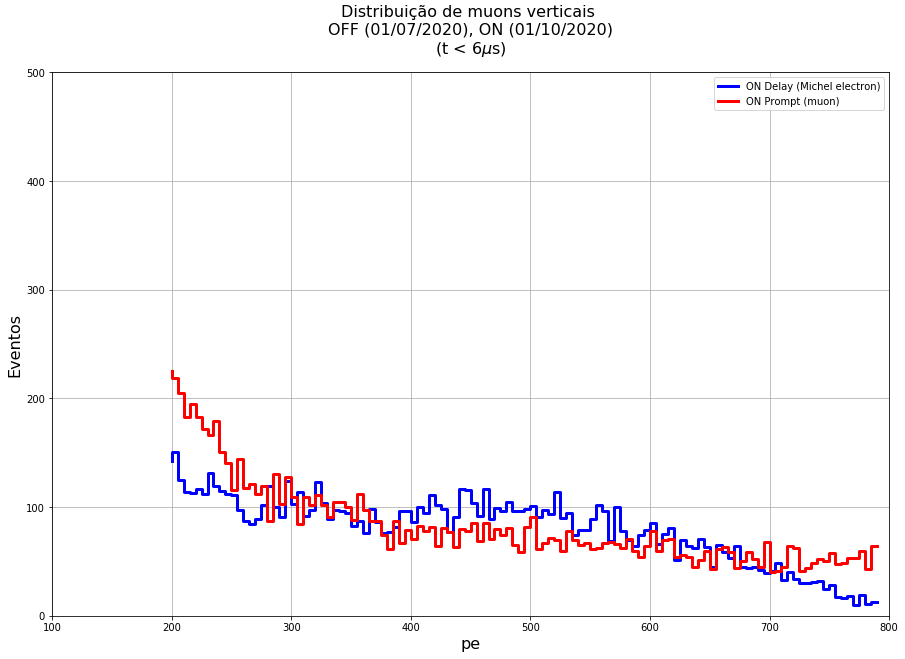

max pe ON =  1901.8086198050285
max pe OFF =  1692.4320164186763
10pe =  0.997 MeV
50pe =  2.505 MeV
100pe =  4.39 MeV
150pe =  6.2749999999999995 MeV
200pe =  8.159999999999998 MeV


In [127]:

fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 10})

#histograma,steps = np.histogram(h_PDP_ON2,bins=np.arange(400,800,10))
histograma1,steps1 = np.histogram(h_PDD_ON1,bins=np.arange(200,800,5))
#histograma1_2,steps1_2 = np.histogram(h_PDD_ON1_2,bins=np.arange(0,1300,5))
#plt.step(steps1[:-1], histograma1-histograma1_2, label='ON Delay (Michel electron)',color='blue', linewidth=3)
plt.step(steps1[:-1], histograma1, label='ON Delay (Michel electron)',color='blue', linewidth=3)

histograma2,steps2 = np.histogram(h_PDP_ON1,bins=np.arange(200,800,5))
plt.step(steps2[:-1], histograma2, label='ON Prompt (muon)',color='red', linewidth=3)

#plt.hist([h_PDP_ON2,h_PDP_OFF2], bins =100, histtype='step', label=['ON','OFF'])
plt.ylabel('Eventos', size=16)
#plt.xlabel('Charge (DUQ)', size=16)
plt.xlabel('pe', size=16)
plt.legend(loc="upper right")
plt.grid()
#plt.xlim(0,300)
plt.xlim(100,800)
plt.ylim(0,500)

plt.title('Distribuição de muons verticais \n'+
          'OFF (01/07/2020), ON (01/10/2020)\n'+
          r'(t < 6$\mu$s)', size=16,y=1.02)
#plt.savefig('histogramas/Hist_Muons_ON_OFF_10d.png')
plt.show()

print('max pe ON = ',max(h_PDP_ON1))
print('max pe OFF = ',max(h_PDP_OFF1))
print('10pe = ',fnt_pe2MeV(10),'MeV')
print('50pe = ',fnt_pe2MeV(50),'MeV')
print('100pe = ',fnt_pe2MeV(100),'MeV')
print('150pe = ',fnt_pe2MeV(150),'MeV')
print('200pe = ',fnt_pe2MeV(200),'MeV')

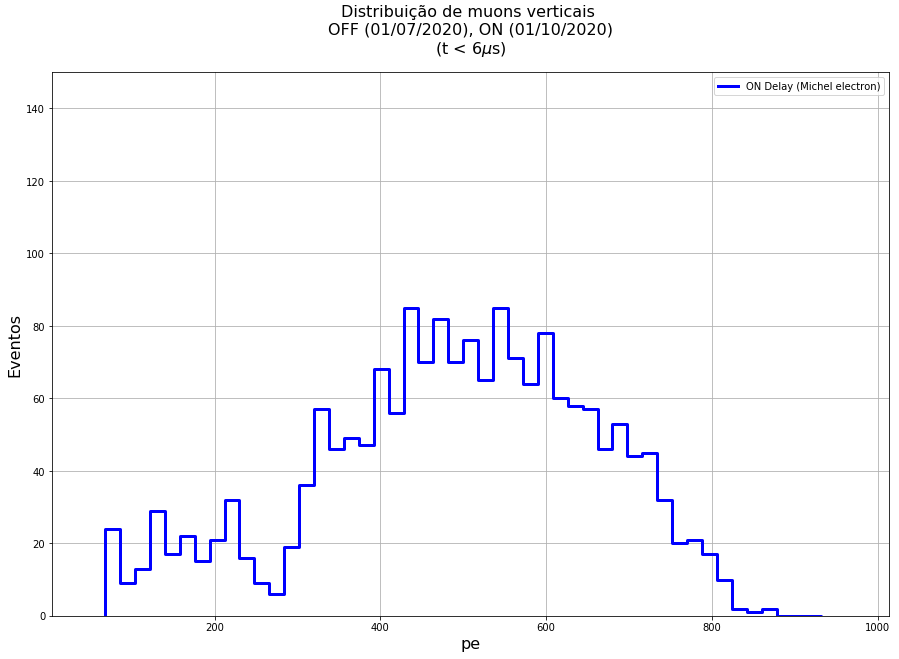

max pe ON =  1901.8086198050285
max pe OFF =  1692.4320164186763
10pe =  0.997 MeV
50pe =  2.505 MeV
100pe =  4.39 MeV
150pe =  6.2749999999999995 MeV
200pe =  8.159999999999998 MeV


In [141]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 10})

histograma1_1,steps1_1 = np.histogram(h_PDD_ON1_1,bins=np.arange(50,1000,18))
histograma1_2,steps1_2 = np.histogram(h_PDD_ON1_2,bins=np.arange(50,1000,18))
plt.step(steps1_1[:-1], histograma1_1-histograma1_2, label='ON Delay (Michel electron)',color='blue', linewidth=3)

plt.ylabel('Eventos', size=16)
plt.xlabel('pe', size=16)
plt.legend(loc="upper right")
plt.grid()
#plt.xlim(0,300)
plt.ylim(0,150)

plt.title('Distribuição de muons verticais \n'+
          'OFF (01/07/2020), ON (01/10/2020)\n'+
          r'(t < 6$\mu$s)', size=16,y=1.02)
#plt.savefig('histogramas/Hist_Muons_ON_OFF_10d.png')
plt.show()

print('max pe ON = ',max(h_PDP_ON1))
print('max pe OFF = ',max(h_PDP_OFF1))
print('10pe = ',fnt_pe2MeV(10),'MeV')
print('50pe = ',fnt_pe2MeV(50),'MeV')
print('100pe = ',fnt_pe2MeV(100),'MeV')
print('150pe = ',fnt_pe2MeV(150),'MeV')
print('200pe = ',fnt_pe2MeV(200),'MeV')

## 10 dias ON / OFF

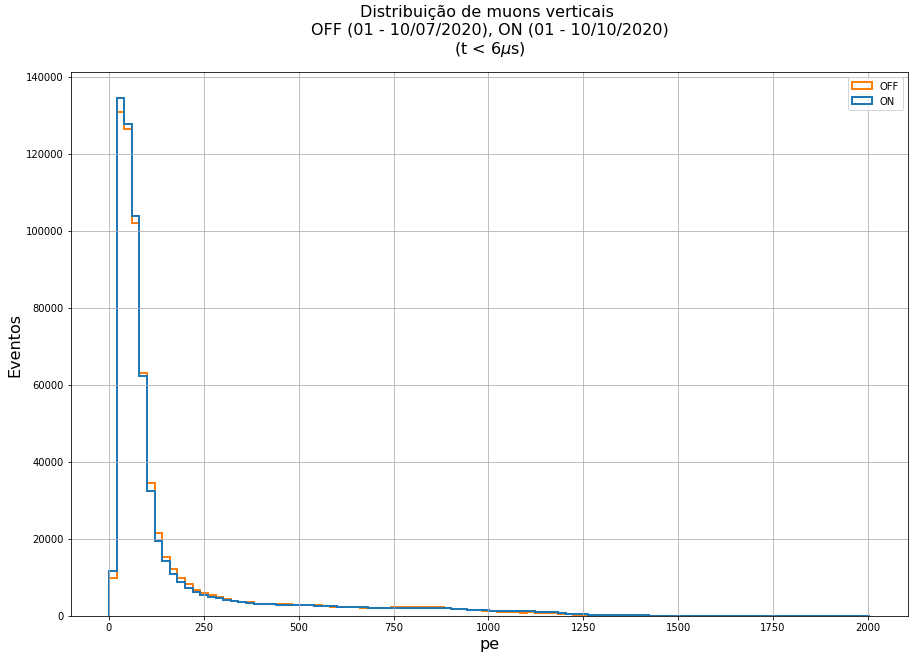

max pe ON =  2005.4899948691639
max pe OFF =  1979.5279630579787
10pe =  0.997 MeV
50pe =  2.505 MeV
100pe =  4.39 MeV
150pe =  6.2749999999999995 MeV
200pe =  8.159999999999998 MeV


In [143]:
#from matplotlib.lines import Line2D

fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 10})

plt.hist([h_PDP_ON2,h_PDP_OFF2], bins =100, histtype='step', label=['ON','OFF'], linewidth=2)
plt.ylabel('Eventos', size=16)
#plt.xlabel('Charge (DUQ)', size=16)
plt.xlabel('pe', size=16)
plt.legend(loc="upper right")
plt.grid()
#plt.xlim(0,300)

plt.title('Distribuição de muons verticais \n'+
          'OFF (01 - 10/07/2020), ON (01 - 10/10/2020)\n'+
          r'(t < 6$\mu$s)', size=16,y=1.02)
plt.savefig('histogramas/Hist_Muons_ON_OFF_10d.png')
plt.show()

print('max pe ON = ',max(h_PDP_ON2))
print('max pe OFF = ',max(h_PDP_OFF2))
print('10pe = ',fnt_pe2MeV(10),'MeV')
print('50pe = ',fnt_pe2MeV(50),'MeV')
print('100pe = ',fnt_pe2MeV(100),'MeV')
print('150pe = ',fnt_pe2MeV(150),'MeV')
print('200pe = ',fnt_pe2MeV(200),'MeV')

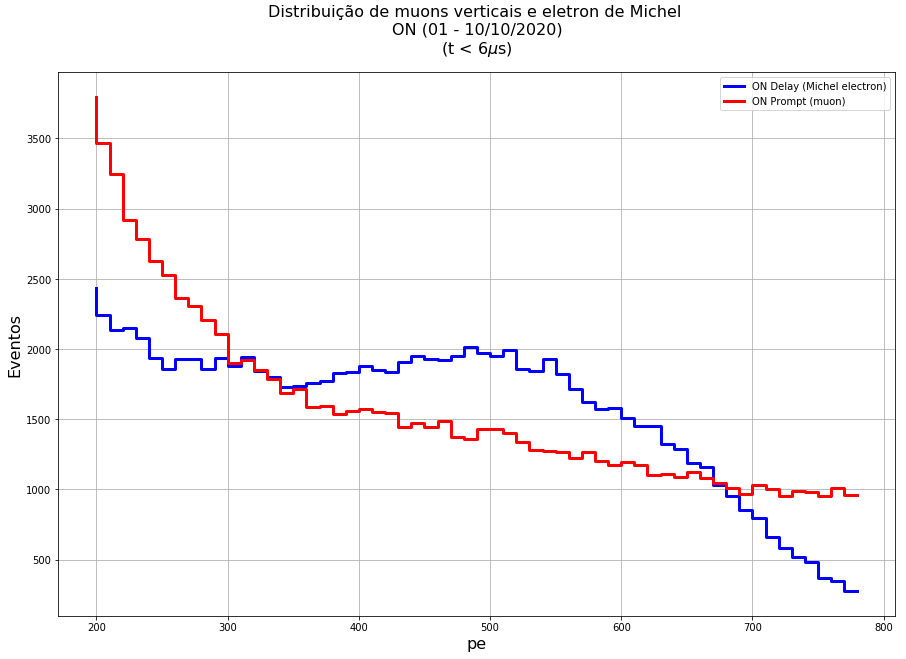

max pe ON =  2005.4899948691639
max pe OFF =  1979.5279630579787
10pe =  0.997 MeV
50pe =  2.505 MeV
100pe =  4.39 MeV
150pe =  6.2749999999999995 MeV
200pe =  8.159999999999998 MeV


In [142]:

fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 10})

#histograma,steps = np.histogram(h_PDP_ON2,bins=np.arange(400,800,10))
histograma1,steps1 = np.histogram(h_PDD_ON2,bins=np.arange(200,800,10))
plt.step(steps1[:-1], histograma1, label='ON Delay (Michel electron)',color='blue', linewidth=3)

histograma2,steps2 = np.histogram(h_PDP_ON2,bins=np.arange(200,800,10))
plt.step(steps2[:-1], histograma2, label='ON Prompt (muon)',color='red', linewidth=3)

#plt.hist([h_PDP_ON2,h_PDP_OFF2], bins =100, histtype='step', label=['ON','OFF'])
plt.ylabel('Eventos', size=16)
#plt.xlabel('Charge (DUQ)', size=16)
plt.xlabel('pe', size=16)
plt.legend(loc="upper right")
plt.grid()
#plt.xlim(0,300)

plt.title('Distribuição de muons verticais e eletron de Michel \n'+
          'ON (01 - 10/10/2020)\n'+
          r'(t < 6$\mu$s)', size=16,y=1.02)
plt.savefig('histogramas/Hist_Muons_EM_ON_zoom_10d.png')
plt.show()

print('max pe ON = ',max(h_PDP_ON2))
print('max pe OFF = ',max(h_PDP_OFF2))
print('10pe = ',fnt_pe2MeV(10),'MeV')
print('50pe = ',fnt_pe2MeV(50),'MeV')
print('100pe = ',fnt_pe2MeV(100),'MeV')
print('150pe = ',fnt_pe2MeV(150),'MeV')
print('200pe = ',fnt_pe2MeV(200),'MeV')

In [ ]:
histograma,steps = np.histogram(df['Total_p_charge'],bins=np.arange(0,200000,1000))
plt.step(steps[:-1], histograma, label='Data',color='blue', linewidth=3)

In [108]:
save_PD (h_PDP_OFF1, h_MUP_OFF1, h_PDD_OFF1, h_MUD_OFF1, h_PDT_OFF1, h_DPMT_OFF1, 'PD_OFF1_1d_Muons_v1')

ValueError: arrays must all be same length

In [90]:
h_PDP_OFF1=[]
h_MUP_OFF1=[]
h_PDD_OFF1=[]
h_MUD_OFF1=[]
h_PDT_OFF1=[]
hg_Sig_OFF1=[]

h_PDP_OFF1, h_MUP_OFF1, h_PDD_OFF1, h_MUD_OFF1, h_PDT_OFF1, hg_Sig_OFF1 = load_PD ('PD_OFF1_7d_v2')

## Salvando em formato XML

In [84]:
import xml.etree.ElementTree as ET

##save values - h_Sig_OFF2 (contém o sigma de cada bin dividido por 5dias)
def save_XML (dh_Hist, dh_Bins, sName):
    # dictionary of lists
    #dict = {'Eventos': dh_Hist,
    #        'Bin': dh_Bins}
    
    # creating a dataframe from dictionary
    #dfw = pd.DataFrame(dict)
    #dfw.to_csv('data/Analise_ONOFF/'+sName+'.csv', index=False, sep=';')
    
    
    data = ET.Element('ONOFF')
    
    for indh in range(len(dh_Hist)):
        e_Hist = str(dh_Hist[indh])
        e_Bin = str(dh_Bins[indh])
 
        element1 = ET.SubElement(data, 'Hist')
        element2 = ET.SubElement(data, 'Bin')

        element1.text = e_Hist
        element2.text = e_Bin
 
        #s_elem1 = ET.SubElement(element1, 'E4')
        #s_elem2 = ET.SubElement(element1, 'D4')
 
        # Adding attributes to the tags under
        #s_elem1.set('type', 'Accepted')
        #s_elem2.set('type', 'Declined')
 
 
    b_xml = ET.tostring(data)
 
    with open('data/Analise_ONOFF/'+sName+'.xml', "wb") as f:
        f.write(b_xml)
    
    #del dict

##save values - h_Sig_OFF2 (contém o sigma de cada bin dividido por 5dias)
#def save_XML_sub (dh_Hist, dh_Bins, dh_Err, sName):
    # dictionary of lists
#    dict = {'Eventos': dh_Hist,
#            'Bin': dh_Bins,
#            'Err': dh_Err}
    
    # creating a dataframe from dictionary
#    dfw = pd.DataFrame(dict)
#    dfw.to_csv('data/Analise_ONOFF/'+sName+'.csv', index=False, sep=';')

#    del dict

In [85]:
save_XML (hist_ONO1[1:], bins_ONO1[1:-1], 'ON1_01Out2020_crit_7d_w')